## GSE190389 – Diurnal mRNA expression profiles from 22 tissues – response to time restricted feeding in mammals

- So here is another study on time restricted feending but now in mice and generaly more encompassing
- 22 organs and brain regions
- 2h over a 24h period
- TRF influences gene expression and significantly increases the amount of rhythmic transcripts
- https://pubmed.ncbi.nlm.nih.gov/36599299/

In [ ]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import custom_func as pc
import matplotlib.pyplot as plt
from umap import UMAP
from pydeseq2.preprocessing import deseq2_norm

### Step 1: Open Dataset

In [8]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE190389_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=adata.X, columns=adata.var.index, index=adata.obs.index).T

#Look at sampeles features
adata.var[['tissue', 'time', 'diet', 'rep']]
adata.var['rep'].unique()
data_df

/Users/maksimsgolubovics/Python_VScode/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Unnamed: 0,Fam175a,Sugp2,Mar-01,Mob3b,Mir145a,1810034E14Rik,Vapa,Grik2,Cacnb2,Crat,Akr1c14,Skap2,Atg4c,Dand5,Mir467e,Desi1,Bcr,Dusp3,Pou5f1-rs6,Itgax,Taar9,Gm16130,Rhog,Ncam1,Sec11c,Ppfia2,Nipal1,Abca4,Fkbp14,Mlx,Kbtbd3,Lrrc74b,Fam126b,Klhdc9,Madd,Patl2,Fubp3,Wac,Grb14,Tagln2,...,Mir9-1,Col11a1,Rfpl4,Olfr668,Tmem163,Fut4-ps1,Rrbp1,2310022B05Rik,Cyp2c70,Snora61,Uhrf1,Tmem233,Herpud1,Bcorl1,Hist1h2aa,Olfr356,Mir1906-2,2010300C02Rik,Ap2m1,Dedd,Tet2,Exosc6,Brpf1,4930452B06Rik,Chil3,Ppp1r17,Lmo3,Aspa,Zbtb10,AA543186,BB031773,Zfp131,4930483K19Rik,Hbb-bs,Mrpl23,Gphn,Cisd3,Tmem107,Nrn1l,Kcne1
Adrenal_ZT0_ALF_1_1,135.0,600.0,44.0,263.0,0.0,39.5,2027.5,57.5,490.5,1319.0,37.0,721.0,308.0,137.0,0.0,1067.5,1026.0,2477.5,0.0,152.5,0.0,7.0,447.5,533.0,364.0,208.0,9.0,1.0,819.5,626.0,64.0,0.0,493.5,3.5,739.0,0.0,494.5,1476.0,414.5,1459.0,...,0.0,119.5,0.0,0.0,27.5,0.0,2855.0,679.5,88.0,2.0,44.0,0.0,1951.5,139.5,0.0,0.0,260.0,77.0,1345.5,432.5,490.0,112.0,510.0,21.0,40.0,70.5,9.0,96.0,142.5,25.0,0.0,598.5,0.0,1403.5,17.0,419.5,678.0,144.5,3.5,1.0
Adrenal_ZT0_ALF_2_1,152.0,392.0,46.5,338.5,0.0,43.5,1483.5,44.0,588.0,1232.0,28.5,666.0,349.5,125.5,0.0,721.5,865.0,2146.5,0.0,198.0,0.0,1.0,344.0,357.5,341.0,140.5,2.0,7.5,815.0,463.5,68.5,0.0,457.5,37.0,491.5,0.0,581.0,1289.0,427.0,1158.0,...,0.0,61.0,2.0,0.0,2.5,0.0,2332.0,653.5,2.5,0.5,31.0,0.0,1026.5,117.5,0.0,0.0,160.5,27.0,1025.0,301.5,341.0,83.0,337.0,40.5,2.5,94.0,12.5,146.0,147.5,22.0,0.0,393.0,0.0,1991.0,12.5,361.0,641.5,112.5,2.0,1.0
Adrenal_ZT0_TRF_1_1,118.5,384.5,75.0,268.0,0.0,42.0,1736.5,60.5,470.5,1590.5,27.0,737.0,331.0,132.5,0.0,829.0,634.0,2078.5,0.0,172.5,0.0,4.0,284.0,421.5,515.5,236.5,7.0,1.5,983.0,582.5,84.0,2.0,632.5,10.5,489.5,0.0,379.0,1440.0,367.0,1375.5,...,0.0,71.0,5.0,0.0,21.5,0.0,2450.0,533.5,17.5,0.0,20.5,0.0,1144.0,74.5,0.0,0.0,165.0,58.5,1168.0,327.5,391.0,106.0,277.5,21.0,31.0,64.0,18.5,161.0,134.5,27.0,0.0,520.0,0.0,1188.0,7.0,406.0,722.0,125.0,1.0,0.0
Adrenal_ZT0_TRF_2_1,127.0,310.5,36.0,261.0,0.0,42.0,1593.0,51.0,470.5,1026.0,50.5,737.5,314.5,95.0,0.0,814.0,638.5,1766.5,0.0,100.5,0.0,1.5,214.0,322.0,380.5,169.0,20.0,5.5,855.0,536.0,72.0,0.0,700.0,8.0,446.5,0.0,384.5,1518.0,330.5,954.5,...,0.0,40.5,0.0,0.0,26.0,0.0,1759.5,323.0,90.0,0.0,26.0,0.0,874.0,87.0,0.0,0.0,123.5,16.5,885.0,254.5,306.0,67.0,242.5,12.5,10.5,41.5,6.0,180.0,138.5,22.0,0.0,552.5,0.0,493.5,12.0,457.0,524.0,101.0,0.0,2.0
Adrenal_ZT2_ALF_1_1,180.0,440.5,71.0,427.0,0.0,54.5,1654.0,45.0,756.0,978.5,24.0,837.5,319.0,139.5,0.0,852.0,1061.5,2397.0,0.0,234.5,0.0,1.5,520.0,353.5,321.5,140.0,9.0,7.0,892.0,521.5,60.0,0.0,412.0,49.0,495.0,1.0,654.0,1525.5,648.5,1458.0,...,0.0,52.0,5.0,0.0,4.0,0.0,2652.5,1067.5,5.0,1.0,55.0,0.0,1046.5,180.0,0.0,0.0,215.5,26.0,1146.0,376.5,484.5,65.0,394.5,31.5,14.0,93.5,16.5,75.5,152.0,17.0,0.0,498.5,0.0,2163.0,9.5,361.5,600.0,148.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stomach_ZT20_TRF_2_1,24.0,65.5,11.0,222.0,2.0,25.5,1104.5,1.5,25.0,723.5,1497.0,204.0,80.0,32.0,0.0,351.0,254.5,246.0,0.0,34.5,0.0,0.0,436.5,65.5,1029.0,1.5,250.0,0.0,42.0,451.0,37.0,2.0,92.0,0.0,285.5,0.0,134.5,440.0,99.0,16496.0,...,0.0,11.0,0.0,0.0,1.0,0.0,3844.5,191.5,93.5,0.0,227.0,0.0,1706.5,66.5,0.0,0.0,2.0,383.0,537.0,304.5,107.0,91.0,134.5,109.5,10.0,0.0,1.0,24.5,41.0,6.0,0.0,132.0,0.0,2084.0,18.0,187.5,285.0,70.5,0.5,82.0
Stomach_ZT22_ALF_1_1,107.0,196.5,26.0,1032.5,3.5,40.5,2968.0,10.5,120.5,1357.0,3328.0,538.0,344.5,60.5,0.0,850.5,809.0,873.5,0.0,62.5,0.0,0.0,403.5,292.0,2009.0,10.0,670.5,3.5,102.0,968.5,89.5,8.0,432.0,2.0,861.0,0.0,541.5,2049.5,180.0,17884.0,...,0.0,81.5,0.0,0.0,13.0,0.0,9263.5,375.0,13.0,5.0,403.5,0.0,4406.5,266.0,0.0,0.0,3.5,661.0,792.0,581.0,614.0,107.0,336.0,348.0,26.0,0.0,3.0,97.0,2

### Step 2: Prepare The Dataset

In [11]:
data_df_norm = deseq2_norm(data_df)[0]
data_df_log = np.log10(data_df_norm + 0.1) #Logarithmic transformation

### Step 3: Exploratory Analysis

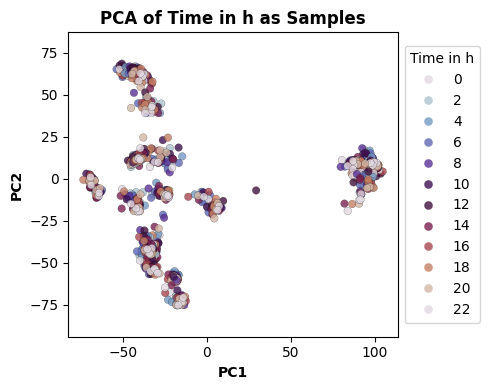

In [12]:
data_df_log_time = data_df_log.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Time in h', c_map='twilight')

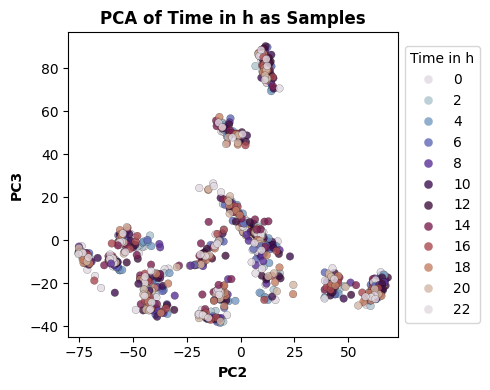

In [13]:
pc.principal_component_2d_timesample(data=data_df_log_time, x=2, y=3, label='Time in h', c_map='twilight')

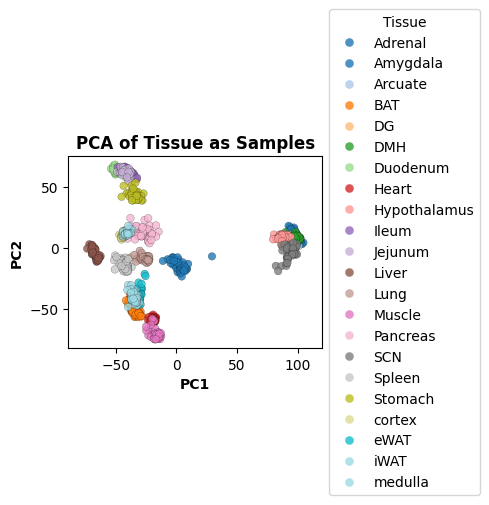

In [14]:
data_df_log_subject = data_df_log.join(adata.var['tissue']).reset_index().set_index('tissue').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, label='Tissue', c_map='tab20')

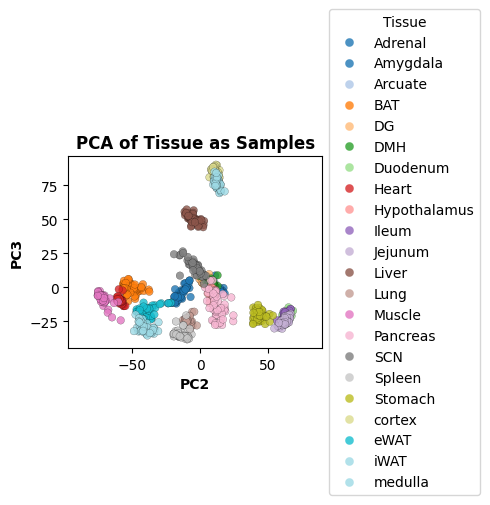

In [15]:
data_df_log_subject = data_df_log.join(adata.var['tissue']).reset_index().set_index('tissue').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, x=2, y=3, label='Tissue', c_map='tab20')

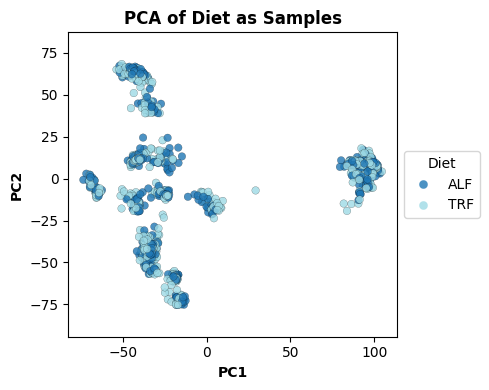

In [16]:
data_df_log_subject = data_df_log.join(adata.var['diet']).reset_index().set_index('diet').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, label='Diet', c_map='tab20')

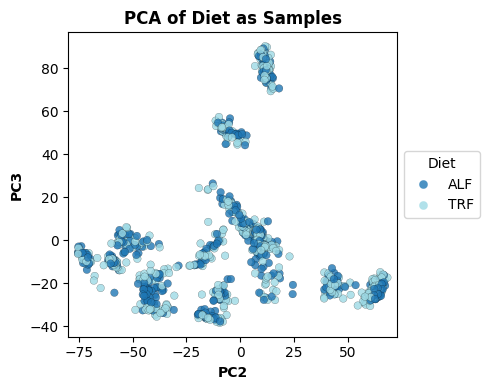

In [17]:
data_df_log_subject = data_df_log.join(adata.var['diet']).reset_index().set_index('diet').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, x=2, y=3, label='Diet', c_map='tab20')

##### In this dataset, I will analyze each organ individually to see how COFE performs in each organ compared to the others.

## COFE: Adrenal

### Identify Mean and Std Threshold valuse

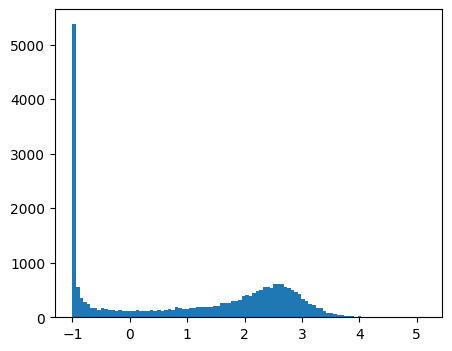

In [18]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log[adata.var['tissue'] == 'Adrenal'].mean(), bins=100);

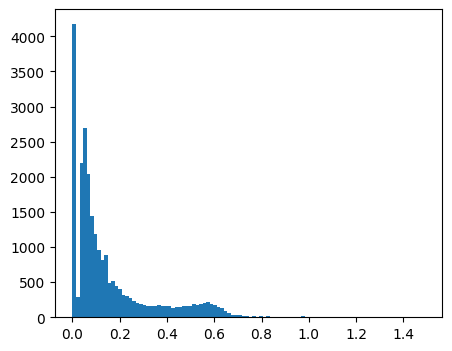

In [19]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log[adata.var['tissue'] == 'Adrenal'].std(), bins=100);

### COFE: Adrenal All Samples

In [21]:
X_train_a = data_df_log[adata.var['tissue'] == 'Adrenal']
true_time_train_a = adata.var[adata.var['tissue'] == 'Adrenal']['time'].astype(int)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=13)
X_train_a.shape # (Samples, Transcripts)

(48, 6418)

In [22]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1)

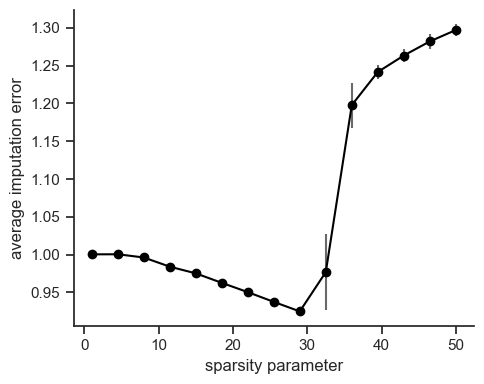

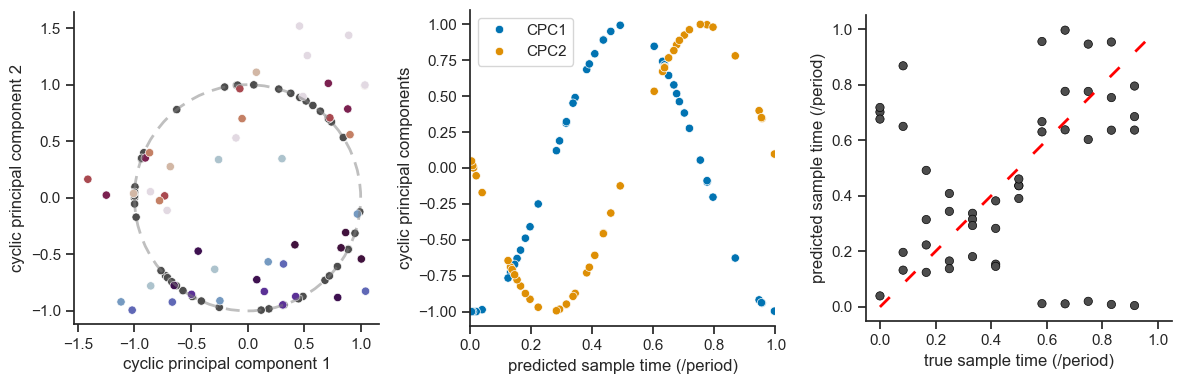

In [23]:
results_train_diet_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=24)

In [24]:
results_train_diet_a["MAPE"]*24

np.float64(2.9029179942451293)

### COFE: Adrenal TRF

In [25]:
X_train_b = data_df_log[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'TRF')]
true_time_train_b = adata.var[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=13)
X_train_b.shape # (Samples, Transcripts)

(24, 6643)

In [26]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1)

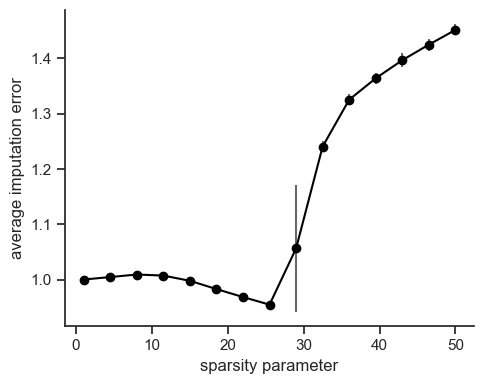

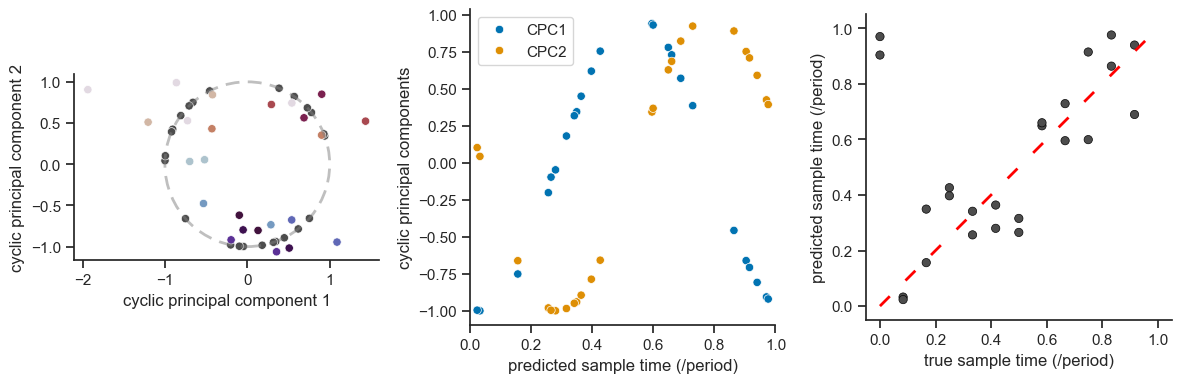

In [27]:
results_train_diet_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=24)

In [28]:
results_train_diet_b["MAPE"]*24

np.float64(1.8445253483888413)

### COFE: Adrenal ALF

In [29]:
X_train_c = data_df_log[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'ALF')]
true_time_train_c = adata.var[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_c, X_test_c, features_c, features_std_c = COFE.analyse.preprocess_data(X_train_c.to_numpy(), None, 
                                                                           features=X_train_c.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=11.2)
X_train_c.shape # (Samples, Transcripts)

(24, 4151)

In [30]:
s_choices = np.linspace(1, 50, 15)
cv_c = COFE.analyse.cross_validate(X_train_c, s_choices, features=features_c, K=5, ncores=-1)

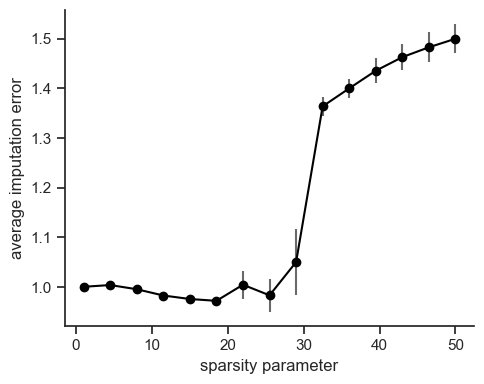

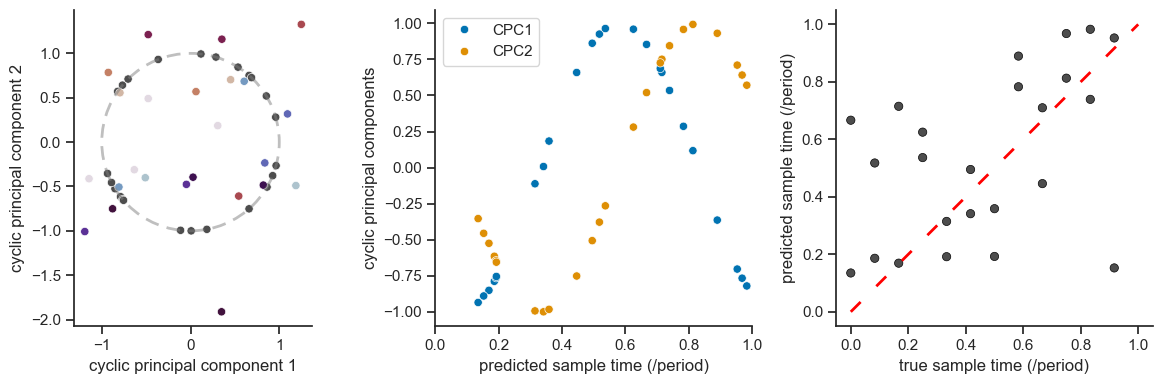

In [31]:
results_train_diet_c = COFE.analyse.predict_time(X_train_c, cv_c, true_times=true_time_train_c.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_c, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_c, time=true_time_train_c.to_numpy(), X=X_train_c, figsize=(12, 4), period=24)

In [32]:
results_train_diet_c["MAPE"]*24

np.float64(3.4935451287162103)

## COFE: Amygdala

### COFE: Amygdala All Samples

In [34]:
X_train_d = data_df_log[(adata.var['tissue'] == 'Amygdala')]
true_time_train_d = adata.var[(adata.var['tissue'] == 'Amygdala')]['time'].astype(int)

X_train_d, X_test_d, features_d, features_std_d = COFE.analyse.preprocess_data(X_train_d.to_numpy(), None, 
                                                                           features=X_train_d.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=13)
X_train_d.shape # (Samples, Transcripts)

(46, 7363)

In [35]:
s_choices = np.linspace(1, 50, 15)
cv_d = COFE.analyse.cross_validate(X_train_d, s_choices, features=features_d, K=5, ncores=-1)

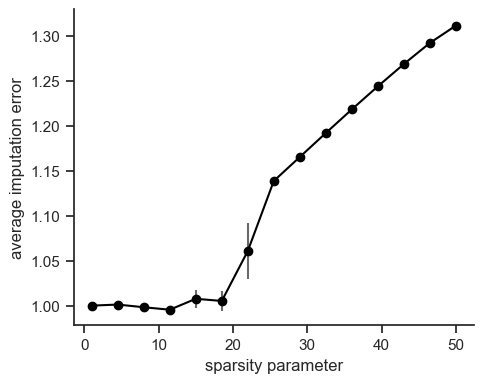

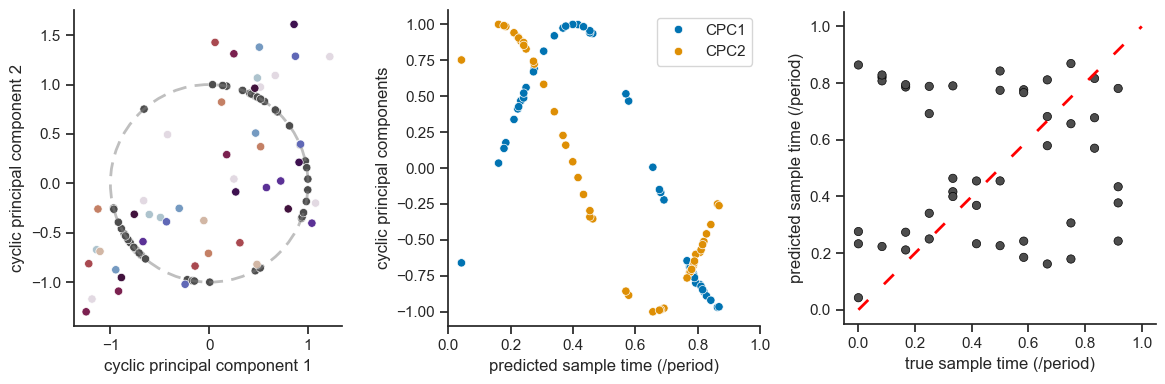

In [36]:
results_train_diet_d = COFE.analyse.predict_time(X_train_d, cv_d, true_times=true_time_train_d.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_d, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_d, time=true_time_train_d.to_numpy(), X=X_train_d, figsize=(12, 4), period=24)

In [37]:
results_train_diet_d["MAPE"]*24

np.float64(4.52266485295351)

### COFE: Amygdala TRF

In [39]:
X_train_e = data_df_log[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'TRF')]
true_time_train_e = adata.var[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_e, X_test_e, features_e, features_std_e = COFE.analyse.preprocess_data(X_train_e.to_numpy(), None, 
                                                                           features=X_train_e.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=13)
X_train_e.shape # (Samples, Transcripts)

(23, 6722)

In [40]:
s_choices = np.linspace(1, 50, 15)
cv_e = COFE.analyse.cross_validate(X_train_e, s_choices, features=features_e, K=5, ncores=-1, restarts=10)

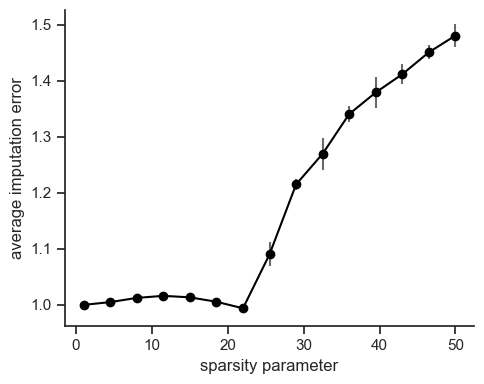

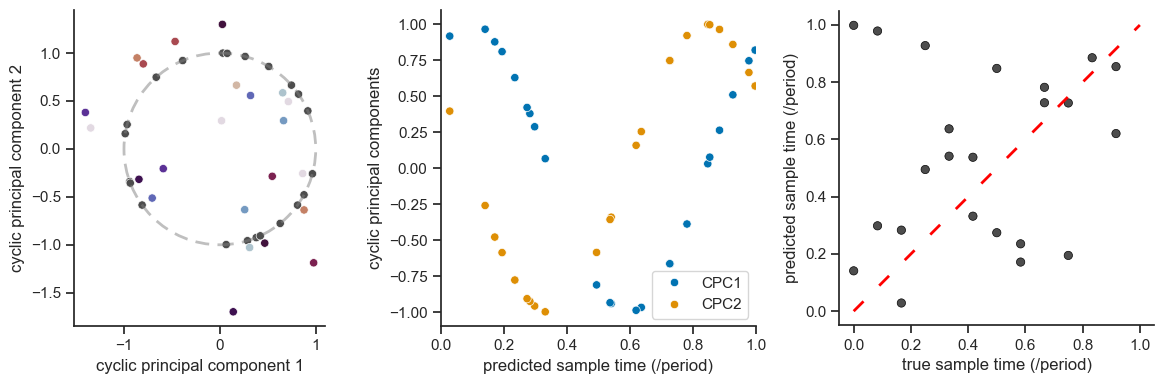

In [41]:
results_train_diet_e = COFE.analyse.predict_time(X_train_e, cv_e, true_times=true_time_train_e.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_e, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_e, time=true_time_train_e.to_numpy(), X=X_train_e, figsize=(12, 4), period=24)

In [42]:
results_train_diet_e["MAPE"]*24

np.float64(3.3828298375773986)

### COFE: Amygdala ALF

In [45]:
X_train_f = data_df_log[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'ALF')]
true_time_train_f = adata.var[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_f, X_test_f, features_f, features_std_f = COFE.analyse.preprocess_data(X_train_f.to_numpy(), None, 
                                                                           features=X_train_f.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=11)
X_train_f.shape # (Samples, Transcripts)

(23, 5961)

In [46]:
s_choices = np.linspace(1, 50, 15)
cv_f = COFE.analyse.cross_validate(X_train_f, s_choices, features=features_f, K=5, ncores=-1)

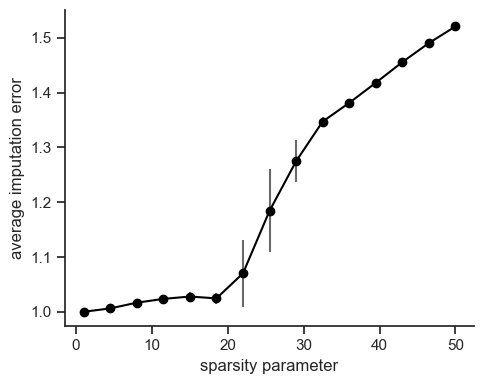

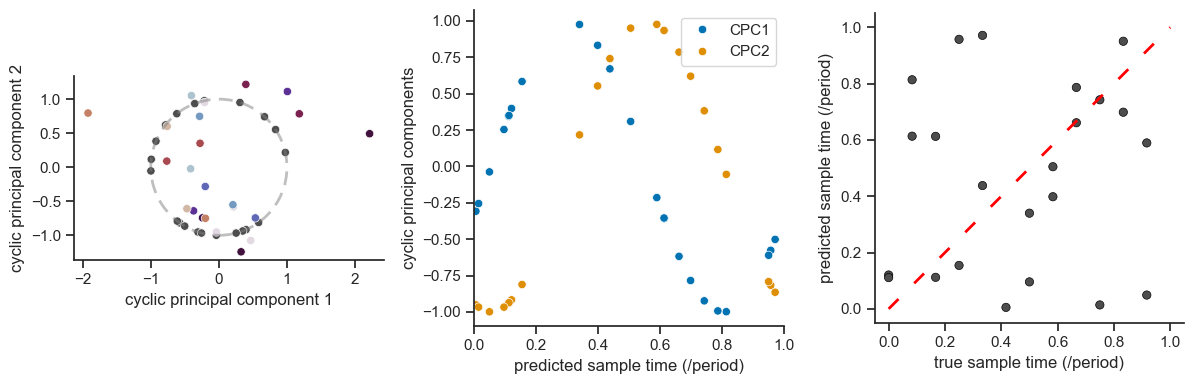

In [47]:
results_train_diet_f = COFE.analyse.predict_time(X_train_f, cv_f, true_times=true_time_train_f.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_f, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_f, time=true_time_train_f.to_numpy(), X=X_train_f, figsize=(12, 4), period=24)

In [48]:
results_train_diet_f["MAPE"]*24

np.float64(3.237000439048847)

## COFE: Arcuate

### COFE: Arcuate All Samples

In [50]:
X_train_g = data_df_log[(adata.var['tissue'] == 'Arcuate')]
true_time_train_g = adata.var[(adata.var['tissue'] == 'Arcuate')]['time'].astype(int)

X_train_g, X_test_g, features_g, features_std_g = COFE.analyse.preprocess_data(X_train_g.to_numpy(), None, 
                                                                           features=X_train_g.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=13)
X_train_g.shape # (Samples, Transcripts)

(46, 6653)

In [51]:
s_choices = np.linspace(1, 50, 15)
cv_g = COFE.analyse.cross_validate(X_train_g, s_choices, features=features_g, K=5, ncores=-1)

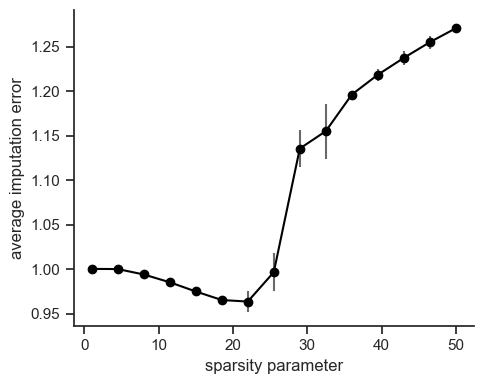

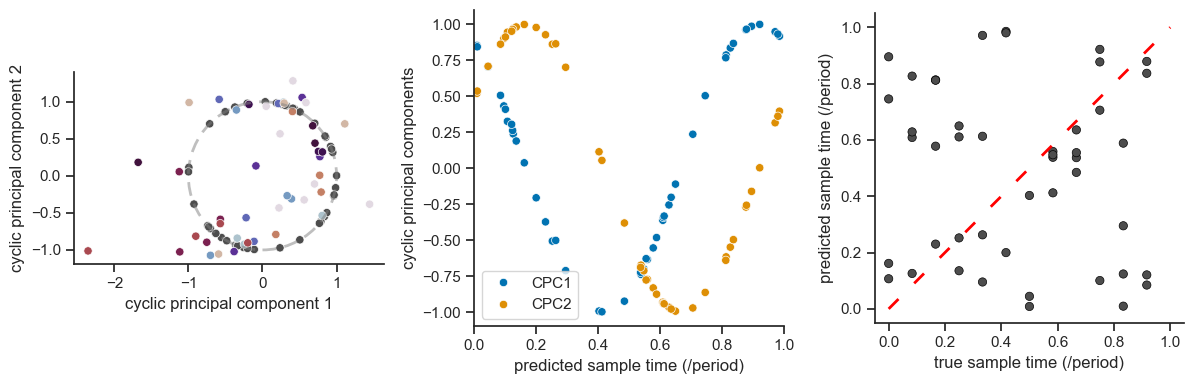

In [52]:
results_train_diet_g = COFE.analyse.predict_time(X_train_g, cv_g, true_times=true_time_train_g.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_g, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_g, time=true_time_train_g.to_numpy(), X=X_train_g, figsize=(12, 4), period=24)

In [53]:
results_train_diet_g["MAPE"]*24

np.float64(4.299258637059053)

### COFE: Arcuate TRF

In [55]:
X_train_k = data_df_log[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'TRF')]
true_time_train_k = adata.var[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_k, X_test_k, features_k, features_std_k = COFE.analyse.preprocess_data(X_train_k.to_numpy(), None, 
                                                                           features=X_train_k.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=13)
X_train_k.shape # (Samples, Transcripts)

(23, 6198)

In [56]:
s_choices = np.linspace(1, 50, 15)
cv_k = COFE.analyse.cross_validate(X_train_k, s_choices, features=features_k, K=5, ncores=-1)

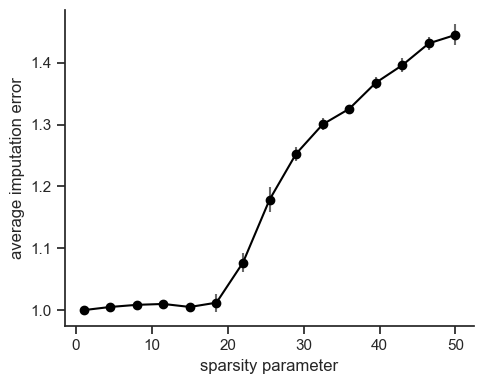

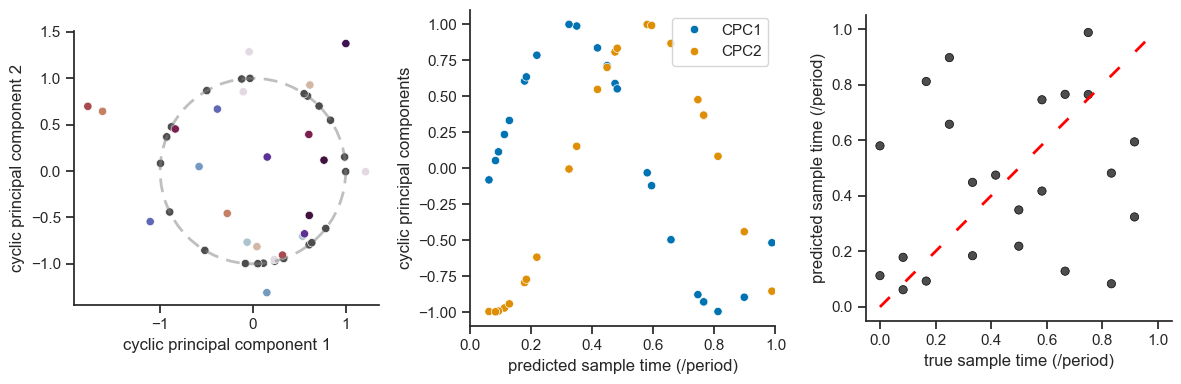

In [57]:
results_train_diet_k = COFE.analyse.predict_time(X_train_k, cv_k, true_times=true_time_train_k.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_k, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_k, time=true_time_train_k.to_numpy(), X=X_train_k, figsize=(12, 4), period=24)

In [58]:
results_train_diet_k["MAPE"]*24

np.float64(3.985037921719673)

### COFE: Arcuate ALF

In [59]:
X_train_l = data_df_log[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'ALF')]
true_time_train_l = adata.var[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_l, X_test_l, features_l, features_std_l = COFE.analyse.preprocess_data(X_train_l.to_numpy(), None, 
                                                                           features=X_train_l.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=11)
X_train_l.shape # (Samples, Transcripts)

(23, 5390)

In [60]:
s_choices = np.linspace(1, 50, 15)
cv_l = COFE.analyse.cross_validate(X_train_l, s_choices, features=features_l, K=5, ncores=-1)

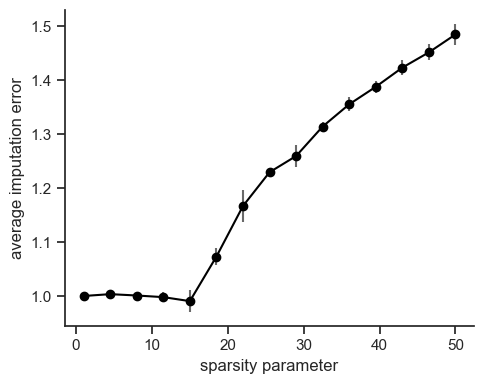

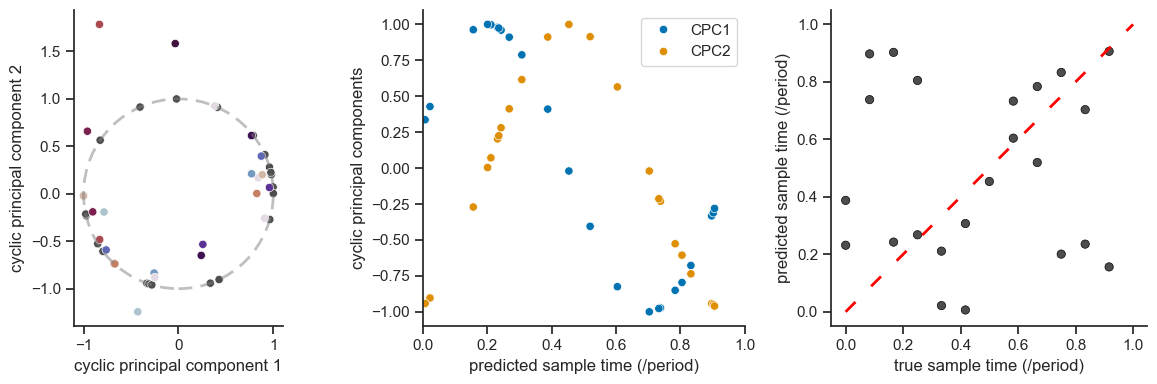

In [61]:
results_train_diet_l = COFE.analyse.predict_time(X_train_l, cv_l, true_times=true_time_train_l.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_l, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_l, time=true_time_train_l.to_numpy(), X=X_train_l, figsize=(12, 4), period=24)

In [62]:
results_train_diet_l["MAPE"]*24

np.float64(3.593273181803432)

## COFE: BAT

### COFE: BAT All Samples

In [65]:
X_train_m = data_df_log[(adata.var['tissue'] == 'BAT')]
true_time_train_m = adata.var[(adata.var['tissue'] == 'BAT')]['time'].astype(int)

X_train_m, X_test_m, features_m, features_std_m = COFE.analyse.preprocess_data(X_train_m.to_numpy(), None, 
                                                                           features=X_train_m.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=12)
X_train_m.shape # (Samples, Transcripts)

(48, 8006)

In [66]:
s_choices = np.linspace(1, 50, 15)
cv_m = COFE.analyse.cross_validate(X_train_m, s_choices, features=features_m, K=5, ncores=-1)

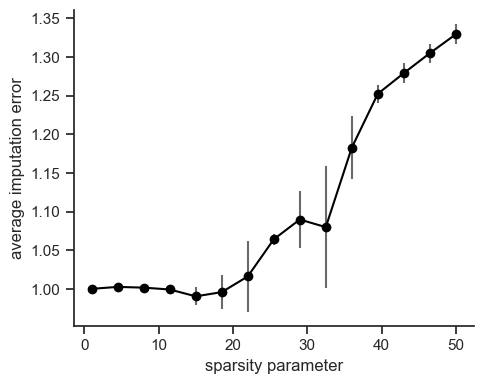

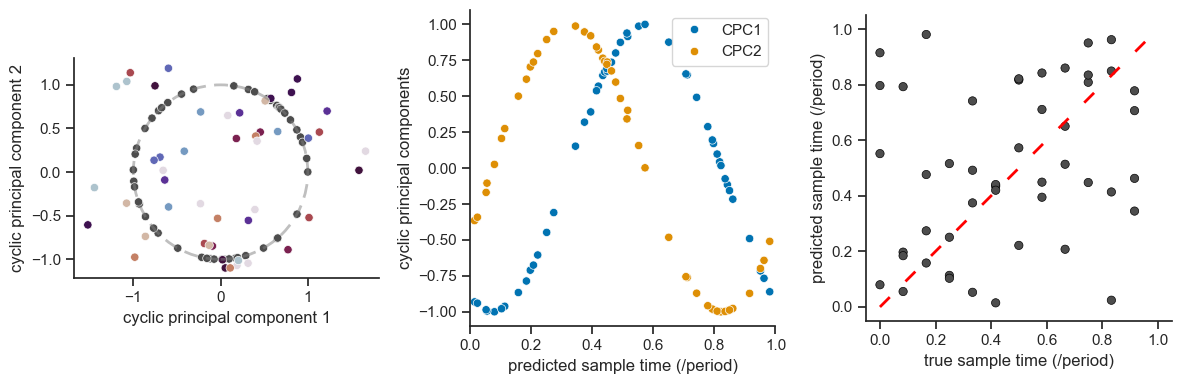

In [67]:
results_train_diet_m = COFE.analyse.predict_time(X_train_m, cv_m, true_times=true_time_train_m.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_m, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_m, time=true_time_train_m.to_numpy(), X=X_train_m, figsize=(12, 4), period=24)

In [68]:
results_train_diet_m["MAPE"]*24

np.float64(3.7414126662910423)

### COFE: BAT TRF

In [87]:
X_train_n = data_df_log[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'TRF')]
true_time_train_n = adata.var[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_n, X_test_n, features_n, features_std_n = COFE.analyse.preprocess_data(X_train_n.to_numpy(), None, 
                                                                           features=X_train_n.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_n.shape # (Samples, Transcripts)

(24, 4586)

In [88]:
s_choices = np.linspace(1, 50, 15)
cv_n = COFE.analyse.cross_validate(X_train_n, s_choices, features=features_n, K=5, ncores=-1, restarts=10)

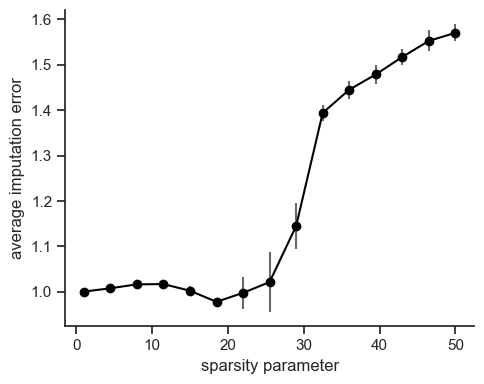

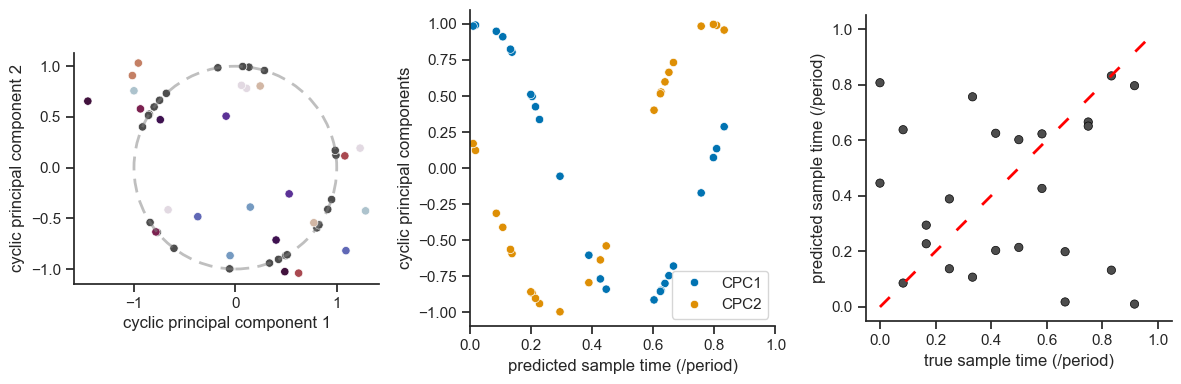

In [89]:
results_train_diet_n = COFE.analyse.predict_time(X_train_n, cv_n, true_times=true_time_train_n.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_n, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_n, time=true_time_train_n.to_numpy(), X=X_train_n, figsize=(12, 4), period=24)

In [90]:
results_train_diet_n["MAPE"]*24

np.float64(3.547708999234999)

### COFE: BAT ALF

In [83]:
X_train_p = data_df_log[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'ALF')]
true_time_train_p = adata.var[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_p, X_test_p, features_p, features_std_p = COFE.analyse.preprocess_data(X_train_p.to_numpy(), None, 
                                                                           features=X_train_p.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_p.shape # (Samples, Transcripts)

(24, 4142)

In [84]:
s_choices = np.linspace(1, 50, 15)
cv_p = COFE.analyse.cross_validate(X_train_p, s_choices, features=features_p, K=5, ncores=-1)

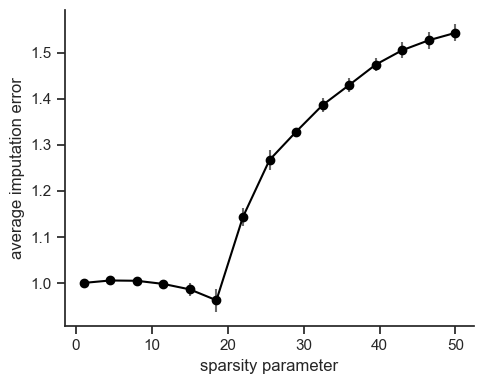

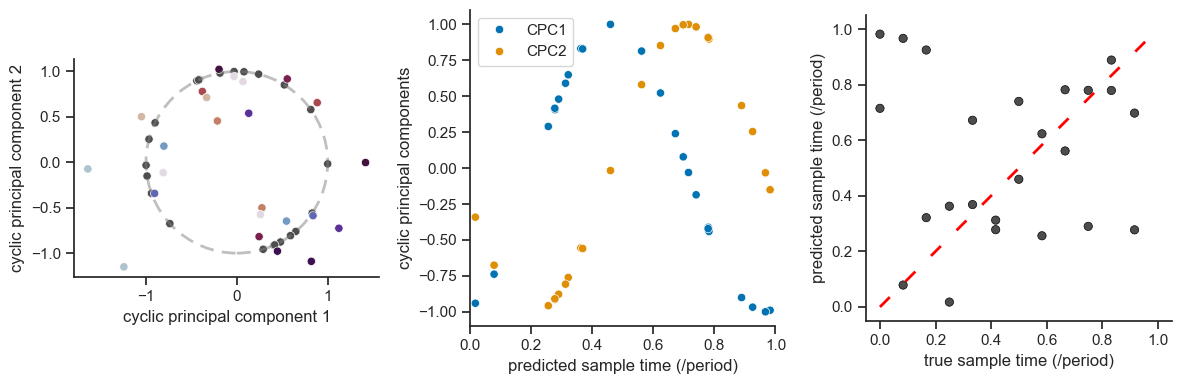

In [85]:
results_train_diet_p = COFE.analyse.predict_time(X_train_p, cv_p, true_times=true_time_train_p.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_p, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_p, time=true_time_train_p.to_numpy(), X=X_train_p, figsize=(12, 4), period=24)

In [86]:
results_train_diet_p["MAPE"]*24

np.float64(2.7802188898547975)

## COFE: Lung

### COFE: Lung All Samples

In [92]:
X_train_1 = data_df_log[(adata.var['tissue'] == 'Lung')]
true_time_train_1 = adata.var[(adata.var['tissue'] == 'Lung')]['time'].astype(int)

X_train_1, X_test_1, features_1, features_std_1 = COFE.analyse.preprocess_data(X_train_1.to_numpy(), None, 
                                                                           features=X_train_1.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_1.shape # (Samples, Transcripts)

(46, 4705)

In [93]:
s_choices = np.linspace(1, 50, 15)
cv_1 = COFE.analyse.cross_validate(X_train_1, s_choices, features=features_1, K=5, ncores=-1)

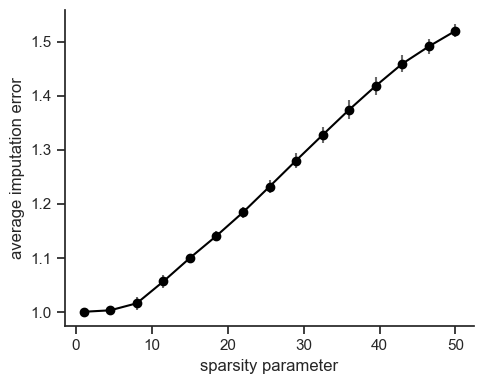

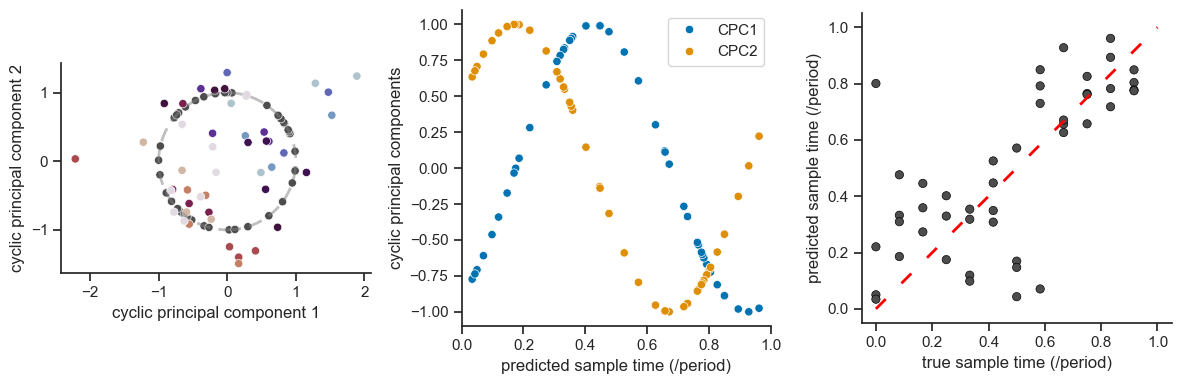

In [94]:
results_train_diet_1 = COFE.analyse.predict_time(X_train_1, cv_1, true_times=true_time_train_1.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_1, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_1, time=true_time_train_1.to_numpy(), X=X_train_1, figsize=(12, 4), period=24)

In [95]:
results_train_diet_1["MAPE"]*24

np.float64(2.6591881792103997)

#### COFE: Lung TRF

In [97]:
X_train_2 = data_df_log[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'TRF')]
true_time_train_2 = adata.var[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_2, X_test_2, features_2, features_std_2 = COFE.analyse.preprocess_data(X_train_2.to_numpy(), None, 
                                                                           features=X_train_2.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=9)
X_train_2.shape # (Samples, Transcripts)

(23, 4847)

In [98]:
s_choices = np.linspace(1, 50, 15)
cv_2 = COFE.analyse.cross_validate(X_train_2, s_choices, features=features_2, K=5, ncores=-1, restarts=10)

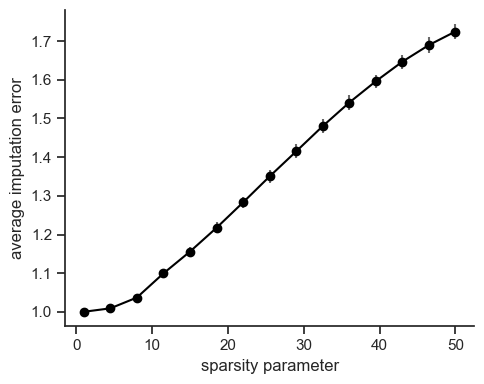

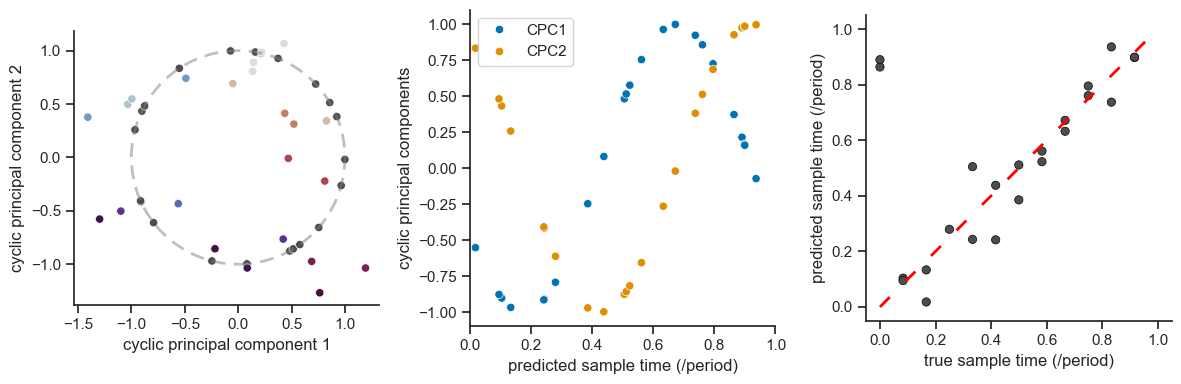

In [99]:
results_train_diet_2 = COFE.analyse.predict_time(X_train_2, cv_2, true_times=true_time_train_2.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_2, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_2, time=true_time_train_2.to_numpy(), X=X_train_2, figsize=(12, 4), period=24)

In [100]:
results_train_diet_2["MAPE"]*24

np.float64(0.8171816090156252)

#### COFE: Lung ALF

In [102]:
X_train_3 = data_df_log[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'ALF')]
true_time_train_3 = adata.var[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_3, X_test_3, features_3, features_std_3 = COFE.analyse.preprocess_data(X_train_3.to_numpy(), None, 
                                                                           features=X_train_3.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_3.shape # (Samples, Transcripts)

(23, 5173)

In [103]:
s_choices = np.linspace(1, 50, 15)
cv_3 = COFE.analyse.cross_validate(X_train_3, s_choices, features=features_3, K=5, ncores=-1)

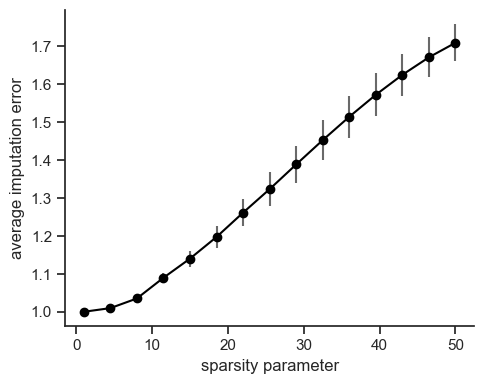

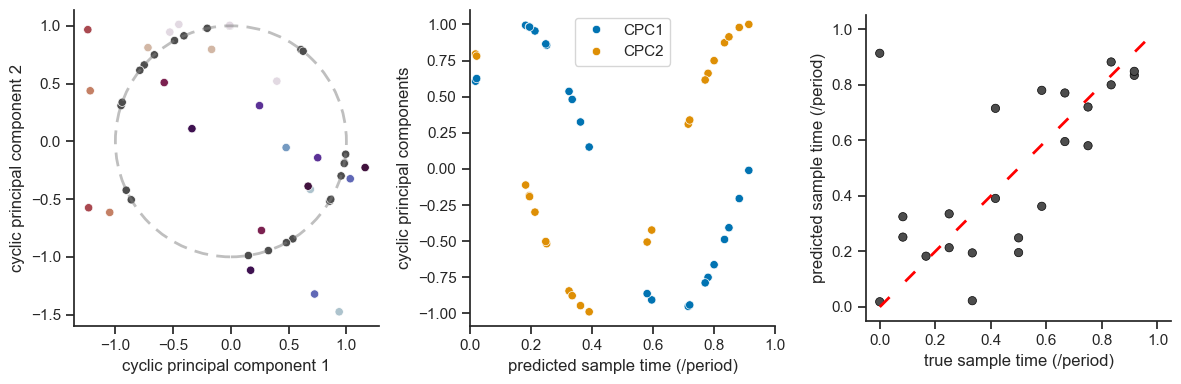

In [104]:
results_train_diet_3 = COFE.analyse.predict_time(X_train_3, cv_3, true_times=true_time_train_3.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_3, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_3, time=true_time_train_3.to_numpy(), X=X_train_3, figsize=(12, 4), period=24)

In [105]:
results_train_diet_3["MAPE"]*24

np.float64(2.078742678041431)

## COFE: Muscle

### COFE: Muscle All Samples

In [107]:
X_train_4 = data_df_log[(adata.var['tissue'] == 'Muscle')]
true_time_train_4 = adata.var[(adata.var['tissue'] == 'Muscle')]['time'].astype(int)

X_train_4, X_test_4, features_4, features_std_4 = COFE.analyse.preprocess_data(X_train_4.to_numpy(), None, 
                                                                           features=X_train_4.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=10)
X_train_4.shape # (Samples, Transcripts)

(48, 4575)

In [108]:
s_choices = np.linspace(1, 50, 15)
cv_4 = COFE.analyse.cross_validate(X_train_4, s_choices, features=features_4, K=5, ncores=-1)

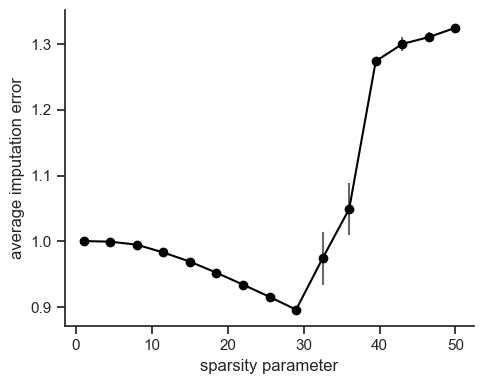

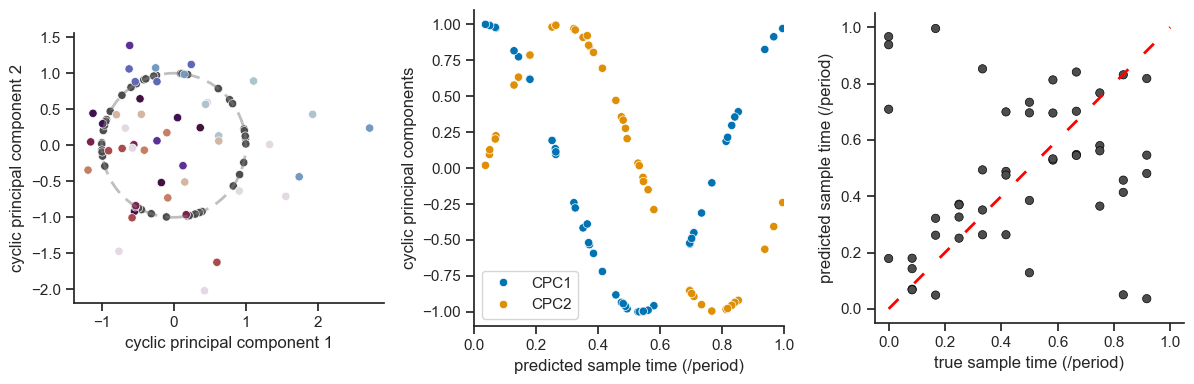

In [109]:
results_train_diet_4 = COFE.analyse.predict_time(X_train_4, cv_4, true_times=true_time_train_4.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_4, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_4, time=true_time_train_4.to_numpy(), X=X_train_4, figsize=(12, 4), period=24)

In [110]:
results_train_diet_4["MAPE"]*24

np.float64(2.865225502162664)

### COFE: Muscle TRF

In [111]:
X_train_5 = data_df_log[(adata.var['tissue'] == 'Muscle')& (adata.var['diet'] == 'TRF')]
true_time_train_5 = adata.var[(adata.var['tissue'] == 'Muscle')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_5, X_test_5, features_5, features_std_5 = COFE.analyse.preprocess_data(X_train_5.to_numpy(), None, 
                                                                           features=X_train_5.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=10)
X_train_5.shape # (Samples, Transcripts)

(24, 4701)

In [112]:
s_choices = np.linspace(1, 50, 15)
cv_5 = COFE.analyse.cross_validate(X_train_5, s_choices, features=features_5, K=5, ncores=-1)

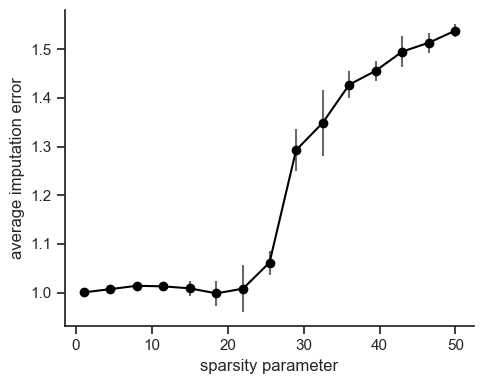

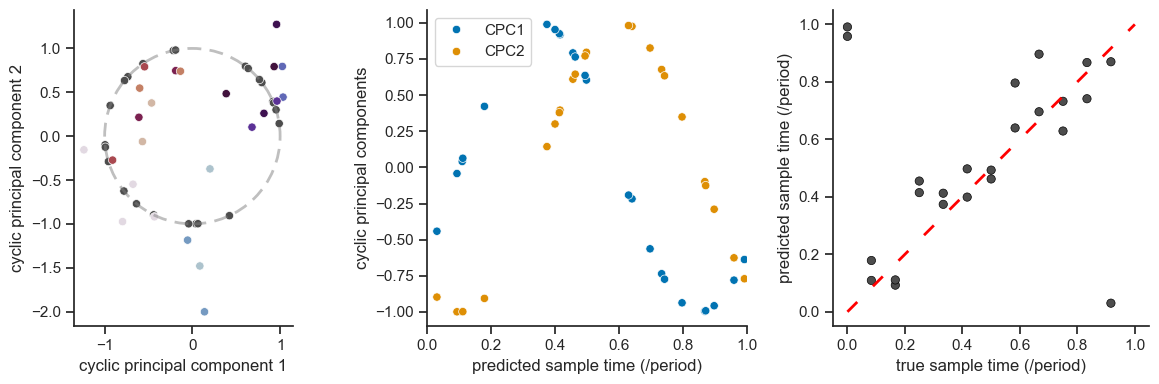

In [113]:
results_train_diet_5 = COFE.analyse.predict_time(X_train_5, cv_5, true_times=true_time_train_5.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_5, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_5, time=true_time_train_5.to_numpy(), X=X_train_5, figsize=(12, 4), period=24)

In [114]:
results_train_diet_5["MAPE"]*24

np.float64(1.34416553628514)

### COFE: Muscle ALF

In [115]:
X_train_6 = data_df_log[(adata.var['tissue'] == 'Muscle')& (adata.var['diet'] == 'ALF')]
true_time_train_6 = adata.var[(adata.var['tissue'] == 'Muscle')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_6, X_test_6, features_6, features_std_6 = COFE.analyse.preprocess_data(X_train_6.to_numpy(), None, 
                                                                           features=X_train_6.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=12)
X_train_6.shape # (Samples, Transcripts)

(24, 4877)

In [116]:
s_choices = np.linspace(1, 50, 15)
cv_6 = COFE.analyse.cross_validate(X_train_6, s_choices, features=features_6, K=5, ncores=-1)

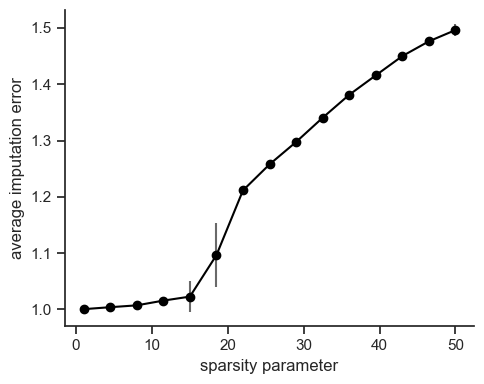

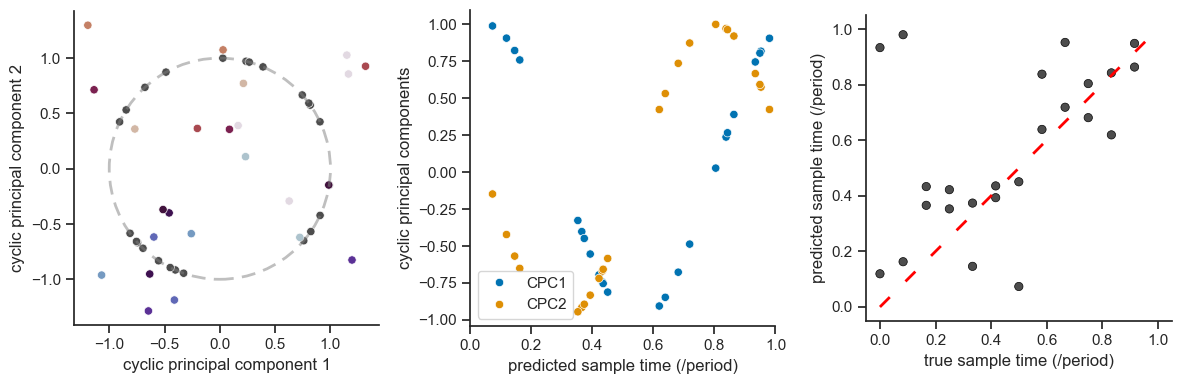

In [117]:
results_train_diet_6 = COFE.analyse.predict_time(X_train_6, cv_6, true_times=true_time_train_6.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_6, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_6, time=true_time_train_6.to_numpy(), X=X_train_6, figsize=(12, 4), period=24)

In [118]:
results_train_diet_6["MAPE"]*24

np.float64(1.7745971748443123)

## COFE: Jejunum

### COFE: Jejunum TRF

In [120]:
X_train_7 = data_df_log[(adata.var['tissue'] == 'Jejunum')& (adata.var['diet'] == 'TRF')]
true_time_train_7 = adata.var[(adata.var['tissue'] == 'Jejunum')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_7, X_test_7, features_7, features_std_7 = COFE.analyse.preprocess_data(X_train_7.to_numpy(), None, 
                                                                           features=X_train_7.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=9)
X_train_7.shape # (Samples, Transcripts)

(24, 5321)

In [121]:
s_choices = np.linspace(1, 50, 15)
cv_7 = COFE.analyse.cross_validate(X_train_7, s_choices, features=features_7, K=5, ncores=-1, restarts=10)

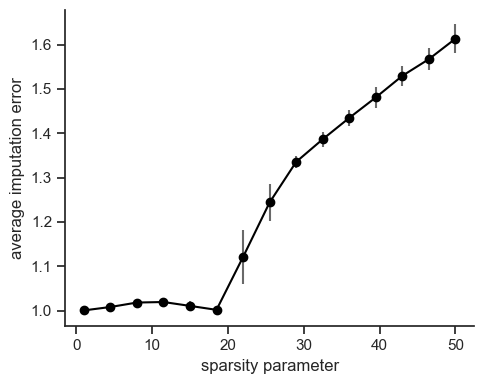

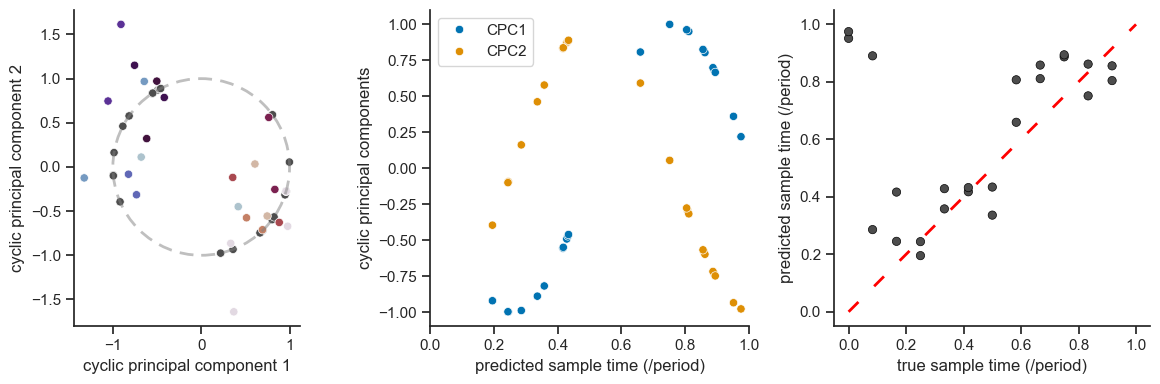

In [122]:
results_train_diet_7 = COFE.analyse.predict_time(X_train_7, cv_7, true_times=true_time_train_7.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_7, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_7, time=true_time_train_7.to_numpy(), X=X_train_7, figsize=(12, 4), period=24)

In [123]:
results_train_diet_7["MAPE"]*24

np.float64(1.926757287750128)

### COFE: Jejunum ALF

In [126]:
X_train_8 = data_df_log[(adata.var['tissue'] == 'Jejunum')& (adata.var['diet'] == 'ALF')]
true_time_train_8 = adata.var[(adata.var['tissue'] == 'Jejunum')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_8, X_test_8, features_8, features_std_8 = COFE.analyse.preprocess_data(X_train_8.to_numpy(), None, 
                                                                           features=X_train_8.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=11)
X_train_8.shape # (Samples, Transcripts)

(24, 4792)

In [127]:
s_choices = np.linspace(1, 50, 15)
cv_8 = COFE.analyse.cross_validate(X_train_8, s_choices, features=features_8, K=5, ncores=-1, restarts=10)

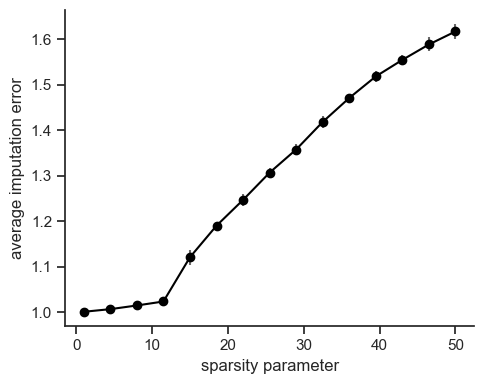

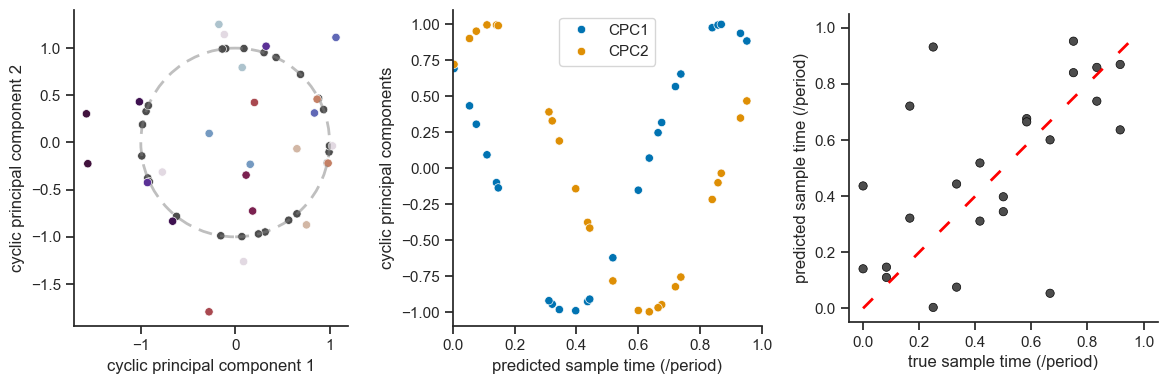

In [128]:
results_train_diet_8 = COFE.analyse.predict_time(X_train_8, cv_8, true_times=true_time_train_8.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_8, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_8, time=true_time_train_8.to_numpy(), X=X_train_8, figsize=(12, 4), period=24)

In [129]:
results_train_diet_8["MAPE"]*24

np.float64(2.5862062097997836)

## COFE: Liver 

### COFE: Liver TRF

In [130]:
X_train_9 = data_df_log[(adata.var['tissue'] == 'Liver')& (adata.var['diet'] == 'TRF')]
true_time_train_9 = adata.var[(adata.var['tissue'] == 'Liver')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_9, X_test_9, features_9, features_std_9 = COFE.analyse.preprocess_data(X_train_9.to_numpy(), None, 
                                                                           features=X_train_9.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=9)
X_train_9.shape # (Samples, Transcripts)

(24, 5379)

In [131]:
s_choices = np.linspace(1, 50, 15)
cv_9 = COFE.analyse.cross_validate(X_train_9, s_choices, features=features_9, K=5, ncores=-1)

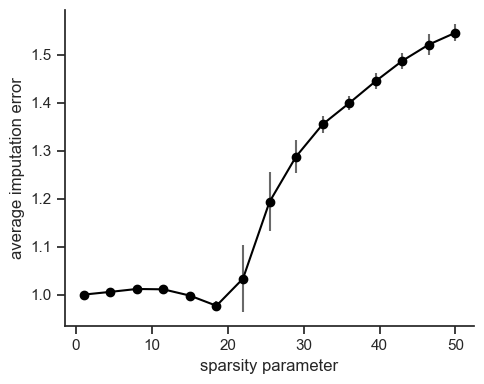

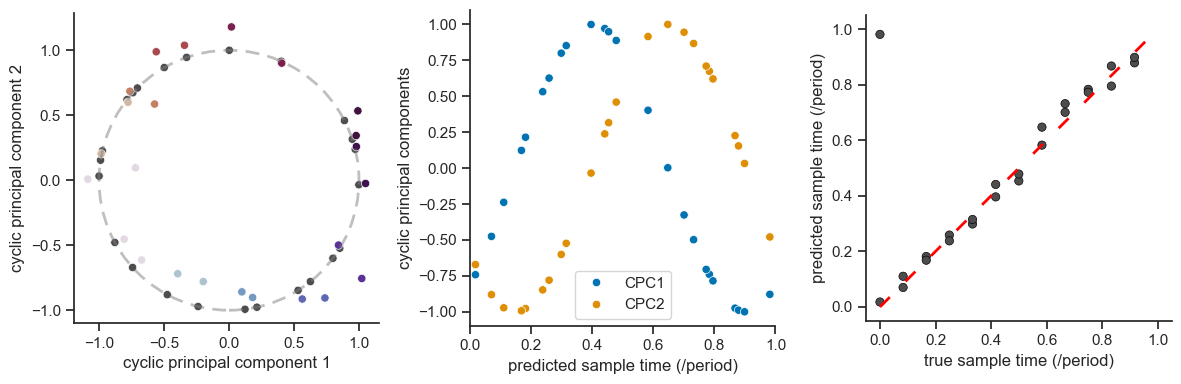

In [132]:
results_train_diet_9 = COFE.analyse.predict_time(X_train_9, cv_9, true_times=true_time_train_9.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_9, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_9, time=true_time_train_9.to_numpy(), X=X_train_9, figsize=(12, 4), period=24)

In [133]:
results_train_diet_9["MAPE"]*24

np.float64(0.5337232713136966)

### COFE: Liver ALF

In [136]:
X_train_10 = data_df_log[(adata.var['tissue'] == 'Liver')& (adata.var['diet'] == 'ALF')]
true_time_train_10 = adata.var[(adata.var['tissue'] == 'Liver')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_10, X_test_10, features_10, features_std_10 = COFE.analyse.preprocess_data(X_train_10.to_numpy(), None, 
                                                                           features=X_train_10.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_10.shape # (Samples, Transcripts)

(24, 4328)

In [137]:
s_choices = np.linspace(1, 50, 15)
cv_10 = COFE.analyse.cross_validate(X_train_10, s_choices, features=features_10, K=5, ncores=-1)

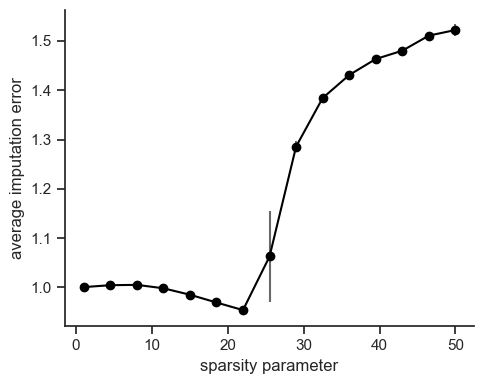

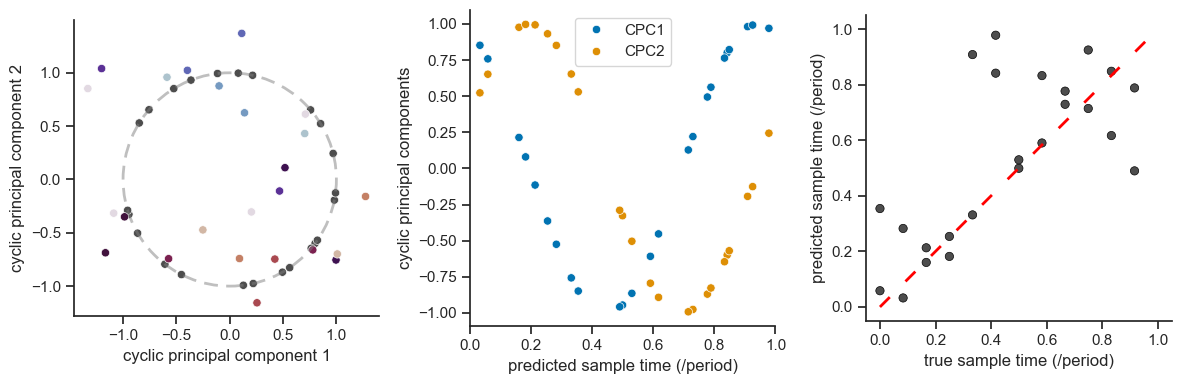

In [138]:
results_train_diet_10 = COFE.analyse.predict_time(X_train_10, cv_10, true_times=true_time_train_10.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_10, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_10, time=true_time_train_10.to_numpy(), X=X_train_10, figsize=(12, 4), period=24)

In [139]:
results_train_diet_10["MAPE"]*24

np.float64(1.5723818843117625)

## COFE: Heart

### COFE: Heart TRF

In [143]:
X_train_11 = data_df_log[(adata.var['tissue'] == 'Heart')& (adata.var['diet'] == 'TRF')]
true_time_train_11 = adata.var[(adata.var['tissue'] == 'Heart')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_11, X_test_11, features_11, features_std_11 = COFE.analyse.preprocess_data(X_train_11.to_numpy(), None, 
                                                                           features=X_train_11.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=14)
X_train_11.shape # (Samples, Transcripts)

(24, 4812)

In [144]:
s_choices = np.linspace(1, 50, 15)
cv_11 = COFE.analyse.cross_validate(X_train_11, s_choices, features=features_11, K=5, ncores=-1, restarts=10)

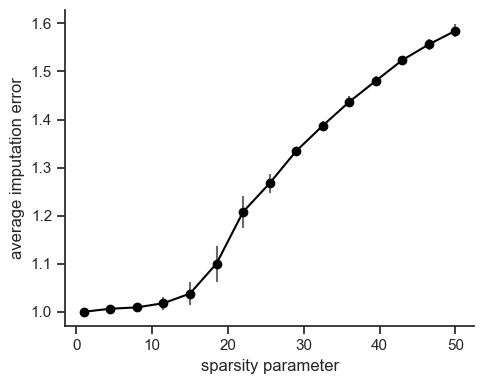

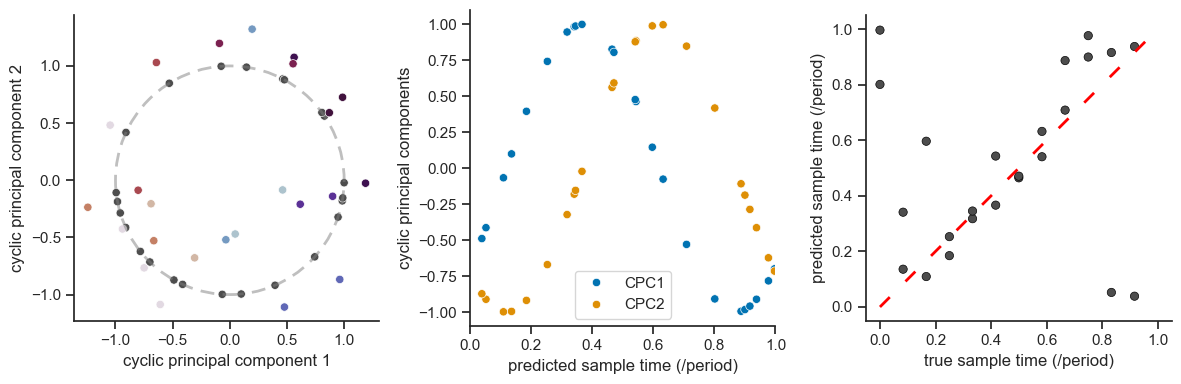

In [145]:
results_train_diet_11 = COFE.analyse.predict_time(X_train_11, cv_11, true_times=true_time_train_11.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_11, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_11, time=true_time_train_11.to_numpy(), X=X_train_11, figsize=(12, 4), period=24)

In [146]:
results_train_diet_11["MAPE"]*24

np.float64(1.3174735369899229)

### COFE: Heart ALF

In [147]:
X_train_12 = data_df_log[(adata.var['tissue'] == 'Heart')& (adata.var['diet'] == 'ALF')]
true_time_train_12 = adata.var[(adata.var['tissue'] == 'Heart')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_12, X_test_12, features_12, features_std_12 = COFE.analyse.preprocess_data(X_train_12.to_numpy(), None, 
                                                                           features=X_train_12.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=14)
X_train_12.shape # (Samples, Transcripts)

(24, 4148)

In [148]:
s_choices = np.linspace(1, 50, 15)
cv_12 = COFE.analyse.cross_validate(X_train_12, s_choices, features=features_12, K=5, ncores=-1)

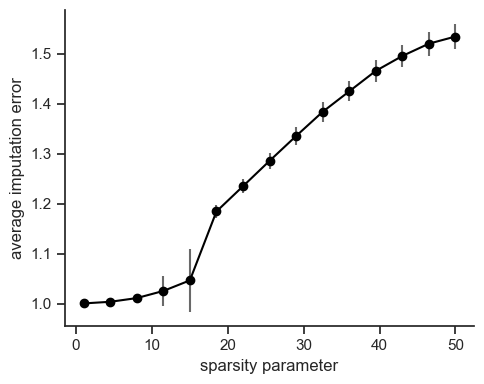

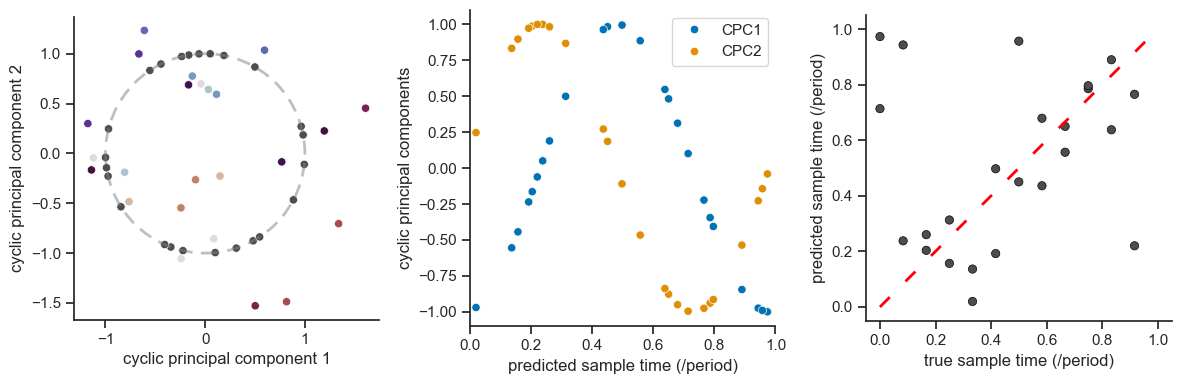

In [149]:
results_train_diet_12 = COFE.analyse.predict_time(X_train_12, cv_12, true_times=true_time_train_12.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_12, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_12, time=true_time_train_12.to_numpy(), X=X_train_12, figsize=(12, 4), period=24)

In [150]:
results_train_diet_12["MAPE"]*24

np.float64(2.4684422528882575)

# Conclusion

So, I only applied COFE to a subset of the tissues/organs, but investigated how COFE predicts time for all samples together and separately for timed restricted and ad libitum feeding groups. As expected, COFE gives a poor prediction when all samples, TRF and ALF togehter, of a given organ are used. The main reason for this is that TRF upregulates a large number of genes and the results are likely to conflict when fewer rhythmic, downregulated genes of ALF are also present in the dataset. However, looking at TRF and ALF samples from each organ in isolation gives an interesting insight into how COFE performs in certain tissue types and how influential factors such as your dietary behavior can be. Below is a brief summary of the MAPE results for specific organs and the number of rhythmic genes identified in these organs (from the paper mentioned in the description).

- Adrenal TRF ->    MAPE: 2.1 -> 2008 genes; ALF ->     MAPE: 4.08 -> 941 genes
- Amygdala TRF ->   MAPE: 2.88 -> 427 genes; ALF ->     MAPE: 3.07 -> 19 genes
- Arcuate TRF ->    MAPE: 2.82 -> 195 genes; ALF ->     MAPE: 3.03 -> 36 genes
- BAT TRF ->        MAPE: 2.16 -> 2996 genes; ALF ->    MAPE: 2.96 -> 617 genes
- Lung TRF ->       MAPE: 1.31 -> 3526 genes; ALF ->    MAPE: 3.00 -> 1617 genes
- Muscle TRF ->     MAPE: 2.35 -> 2162 genes; ALF ->    MAPE: 2.96 -> 902 genes
- Jejunum TRF ->    MAPE: 1.98 -> 4838 genes; ALF ->    MAPE: 2.90 -> 833 genes
- Liver TRF ->      MAPE: 1.90 -> 4174 genes; ALF ->    MAPE: 2.32 -> 1317 genes
- Heart TRF ->      MAPE: 1.77 -> 4218 genes; ALF ->    MAPE: 2.64 -> 2046 genes

Does COFE perform better on TRF samples? It looks that way, but there is a big BUT: The local minimum problem of cross-validation. The found parameters can predict the time series surprisingly well in some cases, while in another, second or third run the MAPE results are very disappointing. Looking at the plot of average imputation error by sparsity parameter it grows to the infinity in many cases, which probably suggest that the prediction will probably be random (if I understand it correctly). Perhaps this is due to the small size of the data set and the fact that 24 samples are not sufficient to make a meaningful prediction. If so, these samples perform quite well even compared to the larger mouse liver data set I analyzed previously.

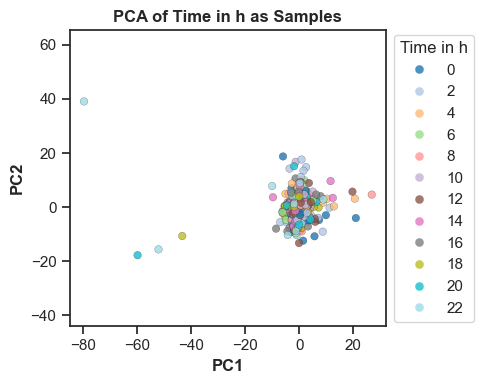

In [151]:
residual_0 = pc.residual_dummy(data=data_df_log.T[data_df_log.mean() > 1].T, data_dummy_1=adata.var['tissue'], columns='tissue')
residual_time = residual_0[adata.var['diet'] == 'TRF'].join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=residual_time, x=1, y=2, label='Time in h', c_map='tab20')

/Users/maksimsgolubovics/Python_VScode/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


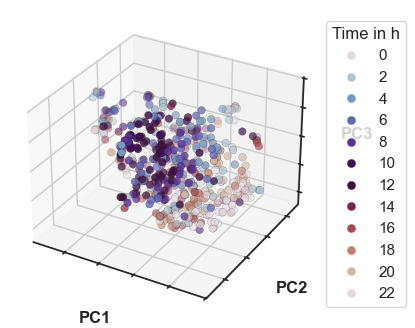

In [152]:

pc.visualization_of_dec_tools_3d(dec=UMAP(n_components=3), data=residual_time, label='Time in h', c_map='twilight')
plt.show()

In [153]:
X_train_13 = residual_0[adata.var['diet'] == 'TRF']
true_time_train_13 = adata.var[(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_13, X_test_13, features_13, features_std_13 = COFE.analyse.preprocess_data(X_train_13.to_numpy(), None, 
                                                                           features=X_train_13.columns, feature_dim='col',
                                                                           mean_threshold=-1, scaling_threshold=4)
X_train_13.shape # (Samples, Transcripts)

(518, 3356)

In [183]:
s_choices = np.linspace(1, 50, 15)
cv_13 = COFE.analyse.cross_validate(X_train_13, s_choices, features=features_13, K=5, ncores=-1)

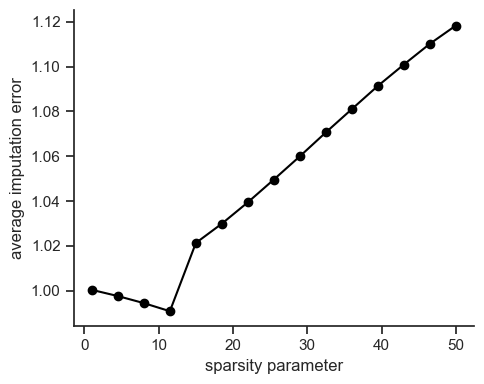

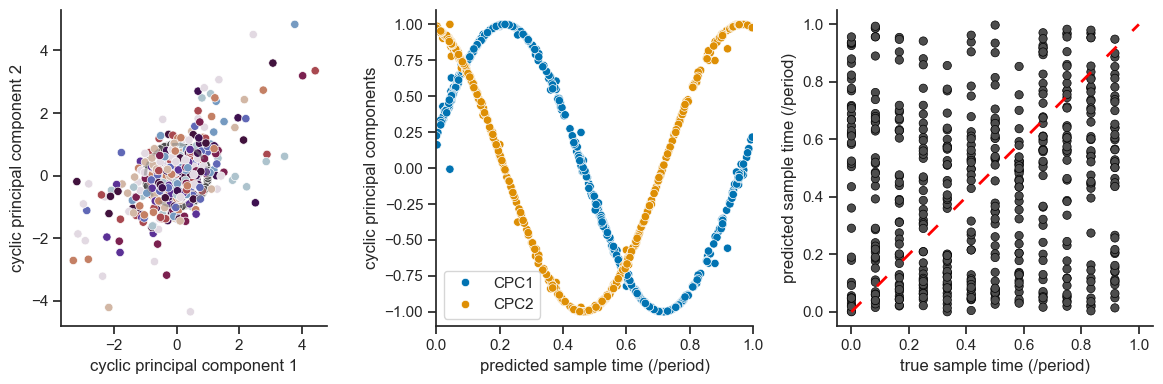

In [184]:
results_train_diet_13 = COFE.analyse.predict_time(X_train_13, cv_13, true_times=true_time_train_13.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_13, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_13, time=true_time_train_13.to_numpy(), X=X_train_13, figsize=(12, 4), period=24)